<a href="https://colab.research.google.com/github/rich-descombaz/colab/blob/master/BoostedTree_with_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try to demonstrate a Boosted Tree
https://www.tensorflow.org/tutorials/estimator/boosted_trees

In [1]:
try:
  import tensorflow.compat.v2 as tf
except Exception:
  pass

tf.enable_v2_behavior()

print(tf.__version__)


2.1.0


In [0]:
!pip uninstall tensorflow  ## if using below 2.0

In [0]:
pip install tensorflow ## update to current


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')


In [6]:
dftrain.shape

(627, 10)

In [7]:
dftrain["survived"]

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64

In [0]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [9]:
dftrain.shape

(627, 9)

In [10]:
type(y_train)

pandas.core.series.Series

In [11]:
dftrain.head

<bound method NDFrame.head of         sex   age  n_siblings_spouses  ...     deck  embark_town alone
0      male  22.0                   1  ...  unknown  Southampton     n
1    female  38.0                   1  ...        C    Cherbourg     n
2    female  26.0                   0  ...  unknown  Southampton     y
3    female  35.0                   1  ...        C  Southampton     n
4      male  28.0                   0  ...  unknown   Queenstown     y
..      ...   ...                 ...  ...      ...          ...   ...
622    male  28.0                   0  ...  unknown  Southampton     y
623    male  25.0                   0  ...  unknown  Southampton     y
624  female  19.0                   0  ...        B  Southampton     y
625  female  28.0                   1  ...  unknown  Southampton     n
626    male  32.0                   0  ...  unknown   Queenstown     y

[627 rows x 9 columns]>

In [12]:
type(dfeval)

pandas.core.frame.DataFrame

In [13]:
type(dftrain)

pandas.core.frame.DataFrame

In [0]:
import tensorflow as tf
tf.random.set_seed(123)

In [15]:
# Explore the data
dftrain.head() 

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [16]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [17]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

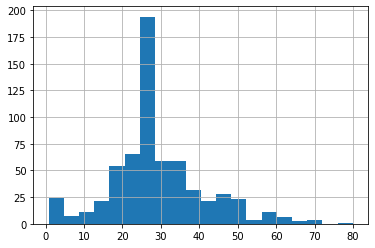

In [18]:
dftrain.age.hist(bins=20)
plt.show()

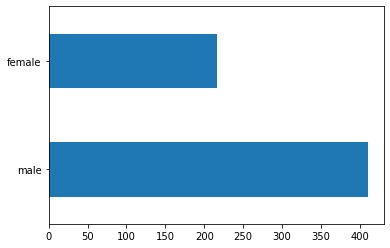

In [19]:
dftrain.sex.value_counts().plot(kind='barh')
plt.show()

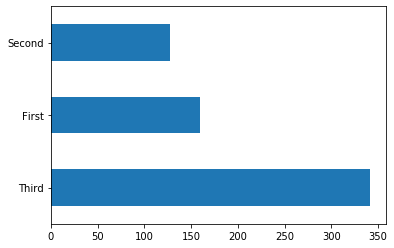

In [20]:
dftrain['class'].value_counts().plot(kind='barh')
plt.show()

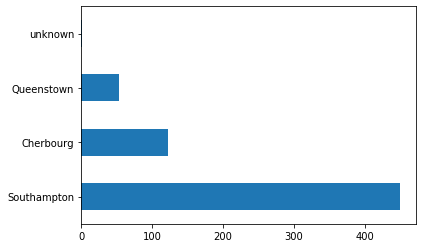

In [21]:
dftrain['embark_town'].value_counts().plot(kind='barh')
plt.show()

In [0]:
#survival 

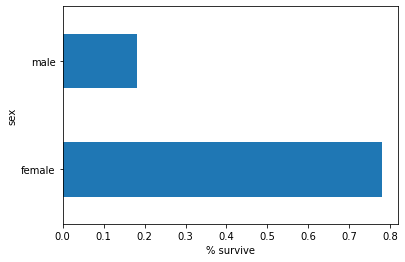

In [22]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.show()

In [0]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

In [24]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
One-hot encoded:  [[0. 0. 1.]]


In [25]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [0]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [28]:
dftrain.shape

(627, 9)

In [29]:
dfeval.shape

(264, 9)

In [30]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


In [0]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.818182
accuracy_baseline         0.625000
auc                       0.859933
auc_precision_recall      0.850304
average_loss              0.419193
label/mean                0.375000
loss                      0.419193
precision                 0.774194
prediction/mean           0.379677
recall                    0.727273
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpho7i3ui0/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


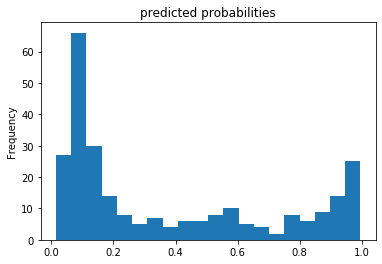

In [0]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

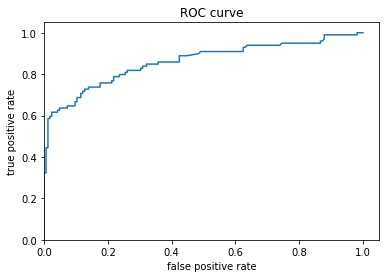

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()